# Naive Bayes Classifer for Sentiment Analysis of film reviews
## written by: Luca Del Basso

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import matplotlib.pyplot as plt
import nltk
stemmer = nltk.PorterStemmer()
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics



## code to implement positive and negative sets of words to use as features

To use the positive and negative word text files I must cite the following paper:

   Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
       Proceedings of the ACM SIGKDD International Conference on Knowledge 
       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, 
       Washington, USA, 
       
I thought using nouns,adjectives,positive and negative words (some combination of the four) as features would imrpove the accuracy score however using all the words as features still seemed to generate the highest accuracy on the development set. After experimenting with a variety of these word sets, using positive and negative words alone yielded the highest results for that particular model.



In [117]:
#I decided to not use adjectives or nouns after testing and as a result have not included the txt files or code 
#implementation of them

positives = set()
with open("positive-words.txt") as pos:
    i = 0
    for word in pos:
        if i >29: #words start at line29  
            positives.add(stemmer.stem(word[:-1]))
        i += 1
        
negatives = set()
with open("negative-words.txt") as neg:
    i = 0
    for word in neg:
        if i >30:#words start at line30
            negatives.add(stemmer.stem(word[:-1]))
        i+=1



In [118]:
pos_negs = positives.union(negatives)

In [119]:
def map_sentiment(df):
    '''takes a dataframe that includes sentiment scores
       returns a dataframe with new sentiment scores'''
    df_c = df.copy()
    df_c.loc[(df.Sentiment == 1), 'Sentiment'] = 0
    df_c.loc[(df.Sentiment == 2), 'Sentiment'] = 1
    df_c.loc[(df.Sentiment == 3) | (df.Sentiment == 4) , 'Sentiment'] = 2

    return df_c

In [120]:
##load raw test,train and development datasets
test_df = pd.read_csv("test.tsv", sep='\t', index_col=0)

train_df = pd.read_csv("train.tsv",sep='\t', index_col=0)

dev_df = pd.read_csv("dev.tsv",sep='\t',index_col=0)

sent_reduct_train_df = map_sentiment(train_df)
sent_reduct_dev_df = map_sentiment(dev_df)

In [121]:

def stem(phrase):
    '''stems each word in a sentence seen in a dataframe'''
    phrase=phrase.split()
    stemmed = [stemmer.stem(word) for word in phrase]
    return ' '.join(stemmed)


def pre_process(dataframe,lowercasing = False,noise_reduction=False, stemm=False):
    '''applies given pre_processing steps to the dataframe before feature extraction'''
    
    df_c = dataframe.copy()
    
    if lowercasing:
        df_c['Phrase'] = df_c['Phrase'].str.lower()       
    if noise_reduction:
        df_c['Phrase'] = df_c['Phrase'].str.replace('[^\w\s]','')  
    if stemm:
        df_c['Phrase'] = df_c['Phrase'].apply(stem)
        
    return df_c

In [122]:
##adjectives only
def feature_extraction(phrase):
    '''extracts certain words as features if they are considered to be
       important words as defined by the word group sets'''
    phrase = phrase.split()
    adjs = [word for word in phrase if  word in pos_negs]#neg_pos_adj_nouns]
    ##in the case that no words are returned, the whole phrase is used
    if len(adjs)==0:
        return " ".join(phrase)
    else:
        return " ".join(adjs)



In [124]:
#noise reduction AND lowercasing for 3 scale

nrlc_3train = pre_process(sent_reduct_train_df,lowercasing=True,noise_reduction=True)
nrlc_3dev = pre_process(sent_reduct_dev_df,lowercasing=True,noise_reduction=True)

#noise reduction AND lowercasing for 5 scale
nrlc_5train = pre_process(train_df,lowercasing=True,noise_reduction=True)
nrlc_5dev = pre_process(dev_df,lowercasing=True,noise_reduction=True)


<ipython-input-121-0388d496ddcd>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_c['Phrase'] = df_c['Phrase'].str.replace('[^\w\s]','')


In [125]:
stem_train_df = pre_process(sent_reduct_train_df,lowercasing=True,noise_reduction=True,stemm=True)
stem_dev_df = pre_process(sent_reduct_dev_df,lowercasing=True,noise_reduction=True,stemm=True)

nrlcs_5train = pre_process(train_df,lowercasing=True,noise_reduction=True,stemm=True)
nrlcs_5dev = pre_process(dev_df,lowercasing=True,noise_reduction=True,stemm=True)

<ipython-input-121-0388d496ddcd>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_c['Phrase'] = df_c['Phrase'].str.replace('[^\w\s]','')


## Training and Classification functions

In [129]:
def training(train):
    '''takes a training set and determines the vocabulary set, a feature vector of feature frequencies,
       the prior probabilities for each class and the likelihoods of all features appearing in the training data'''

    #gather vocabulary set of training data, turn into a list so it has a fixed ordering for vectorization
    vocab = set()
    for phrase in train['Phrase'].values:
        if phrase != None:
            vocab.update(phrase.split())
    vocab = list(vocab)
    
    
    #using the vocabulary of unique features, determine the counts of each feature across every sentence 
    vectorizer = CountVectorizer(vocabulary=vocab)
    word_counts = vectorizer.fit_transform(train['Phrase']).toarray()
    feature_freqs = np.insert(word_counts,0,train['Sentiment'].to_numpy(),axis=1)

    
    #calculate the prior probabilities
    classes = np.unique(feature_freqs[:,0])
    num_classes = len(classes)
    priors = [len(np.where(feature_freqs[:,0]==c)[0])/len(feature_freqs) for c in classes ]
    
    likelihoods = np.zeros((num_classes,len(vocab)))
    ##determine the likelihoods for every feature across every class
    for f in range(len(vocab)):
        col = np.zeros(num_classes)

        col=np.array([
                (np.sum(feature_freqs[:,f+1][feature_freqs[:,0]==c])+1)/((len(np.where(feature_freqs[:,0]==c)[0]) + len(vocab)))
                for c in classes])

        likelihoods[:,f] = col

    return priors,feature_freqs, vocab,likelihoods

In [130]:
def classify(dataframe,priors,vocab,likelihoods,feature_freqs,dev=True):
    '''takes a dataframe and a boolean to determine whether it is againts a development or test set
       returns:
           the probabilites for each class in an array called out
           an array of Ids to use in the tsv write'''
    i = 0
    out = np.zeros((len(priors)+1,len(dataframe)))
    if dev:
        out[-1] = dataframe['Sentiment']
    inds = dataframe.index.tolist()
    maxs = np.zeros(len(dataframe))

    ##return the indexs of the features in the training dataframe, if they exist
    for phr in dataframe['Phrase']:
        phrase = phr.split()
        feature_indexs=np.array([vocab.index(feature) for feature in phrase
                                 if feature in vocab])
        not_in = len(phrase)-len(feature_indexs)
        
        ##if some features dont exist, apply smoothing for their probabilites
        for c in range(len(priors)):
            smoothed = np.array([1/(len(np.where(feature_freqs[:,0]==c)[0]) + len(vocab))]) **not_in
            if feature_indexs.size != 0:
                out[c,i] = priors[c] *np.prod(likelihoods[c,feature_indexs]) *smoothed
            else:
                out[c,i] = priors[c] * smoothed

        i+=1
    return out,inds



## Noise Reduction, lowercasing, all words as features, 3 classes
    -This is one of the models discussed in my report

vocab size:  15297


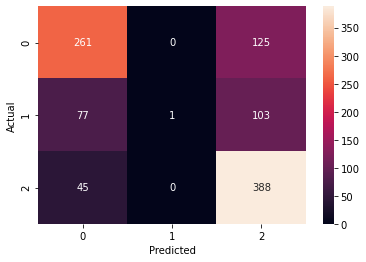

In [131]:
train,dev = nrlc_3train,nrlc_3dev
#test = pre_process(test_df,lowercasing=True,noise_reduction=True)

priors, feature_freqs,vocab,likelihoods = training(train)
out,inds = classify(dev,priors,vocab,likelihoods,feature_freqs,dev=True)
num_classes=len(priors)
predicted = np.argmax(out[0:num_classes],axis=0)
print("vocab size: ",len(vocab))
actual = out[-1]
data = {'actual':actual.astype(int),
        'predicted': predicted}

output = pd.DataFrame(data, columns=['actual','predicted'])
confusion_matrix = pd.crosstab(output['actual'],output['predicted'],rownames=["Actual"],colnames=['Predicted'])
sn.heatmap(confusion_matrix,annot=True,fmt='g')
plt.show()

In [132]:
print("accuracy: ", sklearn.metrics.accuracy_score(actual,predicted))

accuracy:  0.65


## Noise Reduction, lowercasing, all words as features, 5 classes
    

size of vocab: 15297


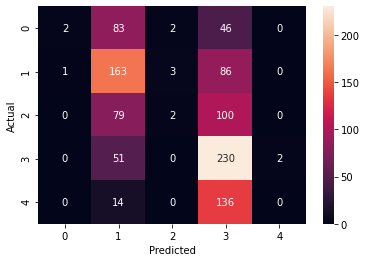

In [133]:
train,dev =nrlc_5train, nrlc_5dev
#test = pre_process(test_df,lowercasing=True,noise_reduction=True)

priors, feature_freqs,vocab,likelihoods = training(train)
num_classes=len(priors)
out,inds = classify(dev,priors,vocab,likelihoods,feature_freqs,dev=True)
print("size of vocab:", len(vocab))

predicted = np.argmax(out[0:num_classes],axis=0)

actual = out[-1]
data = {'actual':actual.astype(int),
        'predicted': predicted}

output = pd.DataFrame(data, columns=['actual','predicted'])
confusion_matrix = pd.crosstab(output['actual'],output['predicted'],rownames=["Actual"],colnames=['Predicted'])
sn.heatmap(confusion_matrix,annot=True,fmt='g')
plt.show()

In [134]:
print("accuracy: ", sklearn.metrics.accuracy_score(actual,predicted))

accuracy:  0.397


## Noise Reduction, lowercasing,stemming, positive and negative words as features, 3 classes
    - This is one of the models discussed in my report

4317


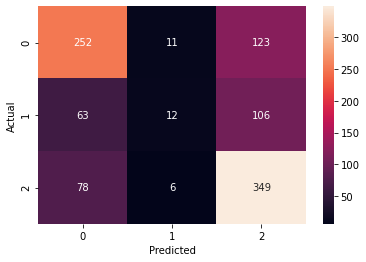

In [136]:
train,dev =stem_train_df, stem_dev_df#nrlc_3train,nrlc_3dev
#test = pre_process(test_df,lowercasing=True,noise_reduction=True)

#feature extraction
dev['Phrase'] = dev['Phrase'].apply(feature_extraction)
train['Phrase'] = train['Phrase'].apply(feature_extraction)

priors, feature_freqs,vocab,likelihoods = training(train)
num_classes=len(priors)
out,inds = classify(dev,priors,vocab,likelihoods,feature_freqs,dev=True)
print(len(vocab))
predicted = np.argmax(out[0:num_classes],axis=0)

actual = out[-1]
data = {'actual':actual.astype(int),
        'predicted': predicted}

output = pd.DataFrame(data, columns=['actual','predicted'])
confusion_matrix = pd.crosstab(output['actual'],output['predicted'],rownames=["Actual"],colnames=['Predicted'])
sn.heatmap(confusion_matrix,annot=True,fmt='g')
plt.show()

In [137]:
print("accuracy: ", sklearn.metrics.accuracy_score(actual,predicted))

accuracy:  0.613


## Noise Reduction, lowercasing,positive and negative words as features, 5 classes

size of vocab 4317


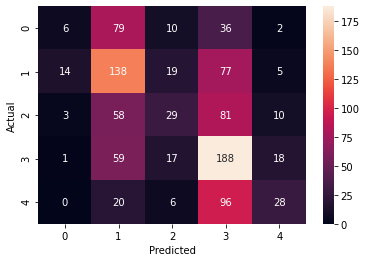

In [138]:
train,dev =nrlcs_5train,nrlcs_5dev
#test = pre_process(test_df,lowercasing=True,noise_reduction=True)
dev['Phrase'] = dev['Phrase'].apply(feature_extraction)
train['Phrase'] = train['Phrase'].apply(feature_extraction)
priors, feature_freqs,vocab,likelihoods = training(train)
print("size of vocab", len(vocab))
num_classes=len(priors)
out,inds = classify(dev,priors,vocab,likelihoods,feature_freqs,dev=True)

predicted = np.argmax(out[0:num_classes],axis=0)

actual = out[-1]
data = {'actual':actual.astype(int),
        'predicted': predicted}

output = pd.DataFrame(data, columns=['actual','predicted'])
confusion_matrix = pd.crosstab(output['actual'],output['predicted'],rownames=["Actual"],colnames=['Predicted'])
sn.heatmap(confusion_matrix,annot=True,fmt='g')
plt.show()

In [139]:
print("accuracy: ", sklearn.metrics.accuracy_score(actual,predicted))

accuracy:  0.389


## example of writing to tsv

In [140]:
# train =nrlc_3train
# test = pre_process(test_df,lowercasing=True,noise_reduction=True)
# # train['Phrase'] = train['Phrase'].apply(feature_extraction)
# # test['Phrase'] = test['Phrase'].apply(feature_extraction)

# priors, feature_freqs,vocab,likelihoods = training(train)
# num_classes=len(priors)
# out,inds = classify(test,priors,vocab,likelihoods,feature_freqs,dev=False)
# predicted = np.argmax(out[0:num_classes],axis=0)

# f = open("test_predictions_3classes_Luca_DELBASSO.tsv","w")
# for i in range(len(inds)):
#     string = str(inds[i]) + "\t" + str(predicted[i])+"\n"
#     f.write(string)
# f.close()

<ipython-input-121-0388d496ddcd>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_c['Phrase'] = df_c['Phrase'].str.replace('[^\w\s]','')
